Author: Dr. Long Chen (long.chen@glasgow.ac.uk) and Dr. Qunshan Zhao (Qunshan.Zhao@glasgow.ac.uk)



The 10-Step Machine Learning Pipeline (My Version):
1. Define business object/research questions
2. Make sense of the data from a high level
    - data types (number, text, object, etc.)
    - continuous/discrete
    - scales and distributions of different features
3. Create the traning and test sets using proper sampling methods, e.g., random vs. stratified
4. Correlation analysis (pair-wise and attribute combinations)
5. Data cleaning (missing data, outliers, data errors)
6. Data transformation via pipelines (categorical text to number using dummy variables, feature scaling via normalization/standardization, feature combinations)
7. Train and cross validate different models and select the most promising one (Linear Regression, Lasso/Ridge/Elastic Net, and Random Forest were tried in this tutorial)
8. Fine tune the model using trying different combinations of hyperparameters
9. Evaluate the model with best estimators in the test set
10. Launch, monitor, and refresh the model and system

A few of general guideline:
1. This session will aim to give you some practical knowledge about machine learning, but theoretical knowledge is important in machine learning as well. To have a deep understanding of machine learning, I would recommend you to have a look at Andrew Ng's lecture, which explains linear regression from scrach
https://www.youtube.com/watch?v=4b4MUYve_U8&t=3161s&ab_channel=stanfordonline.
2. If you want to run a machine learning algorithm, you would better to have at least 2000-3000 samples, otherwise the performance is not necessary better than the traditional methods such as linear regression or GLM.
3. Deep learning may have a better result if the sample size is very large (> 10,000 samples), otherwise general machine learning algorithm will be enough. If you want to learn more of the deep learning, you can check out this book: Dive into Deep Learning (https://d2l.ai/)

In [5]:
#import some necessary librairies
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

This notebook is a solution example for Kaggle challenge: House Prices: Advanced Regression Techniques. 

The dataset and problem explanation can be found here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview. 

Question 1: How many features in the training dataset? How many featuers in the testing dataset? 

Question 2: How many records in the training and testing dataset?

In [6]:
# Now let's import and put the train and test datasets in  pandas dataframe
 
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')


In [7]:
##display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
##display the first five rows of the test dataset.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [9]:
#train.describe()#check the numbers of samples and features
print(f"The train data size before dropping Id feature is : {train.shape} ")
print(f"The test data size before dropping Id feature is : {test.shape} ")

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print(f"\nThe train data size after dropping Id feature is : {train.shape} ")
print(f"The test data size after dropping Id feature is : {test.shape} ")

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


c:\users\long chen\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2882: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  exec(code_obj, self.user_global_ns, self.user_ns)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002550AFE7438>,
      dtype=object)

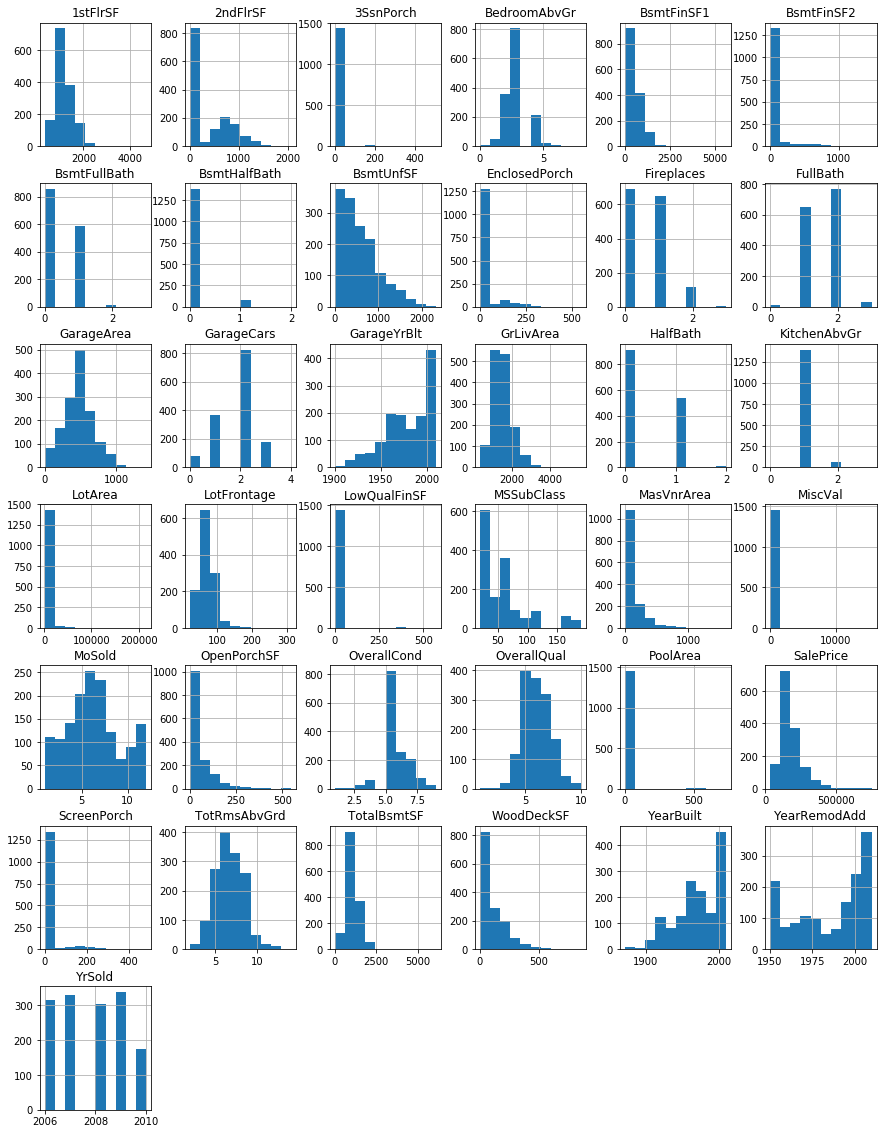

In [10]:
fig,ax = plt.subplots(figsize=(15,20))
train.hist(ax = ax)

In [11]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

## Make Sence of the Data
What are the typical things we can learn from the basic statistics with visualizaitons? 
1. Do the data make sence? scan each column and see whether the data make sense at a high level. 
    
    -  house value data is OK and this is our target variable, i.e., we want to build a model to predict this value.
 
2. Feature scaling: you have noticed that the features have very different scales, which we need to handle later
3. Distribution: from the histograms, we can tell many of them are skewed, i.e., having a long tail on one side or the other. In many cases, we need to transform the data so that they have more bell-shaped distributions.

## Target Variable


**SalePrice** is the variable we need to predict. So let's do some analysis on this variable first.

Normality Test

c:\users\long chen\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'SalePrice distribution')

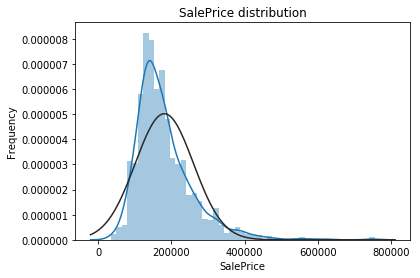

In [12]:
sns.distplot(train['SalePrice'], fit=norm );
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train['SalePrice'], plot=plt)
# plt.show()

# Data Processing

Target Variable: SalePrice

Question: What did we do here and why?

c:\users\long chen\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'SalePrice distribution')

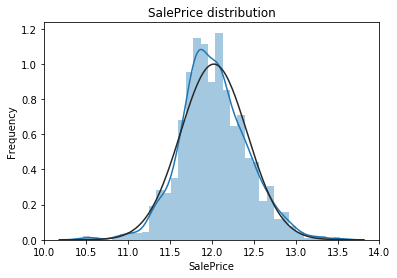

In [13]:
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])


plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# #Get also the QQ-plot
# fig = plt.figure()
# res = stats.probplot(train['SalePrice'], plot=plt)
# plt.show()

The skew seems now corrected and the data appears more normally distributed. 

## Correlation Analysis

Question: What's your findings in this big correlation matrix?

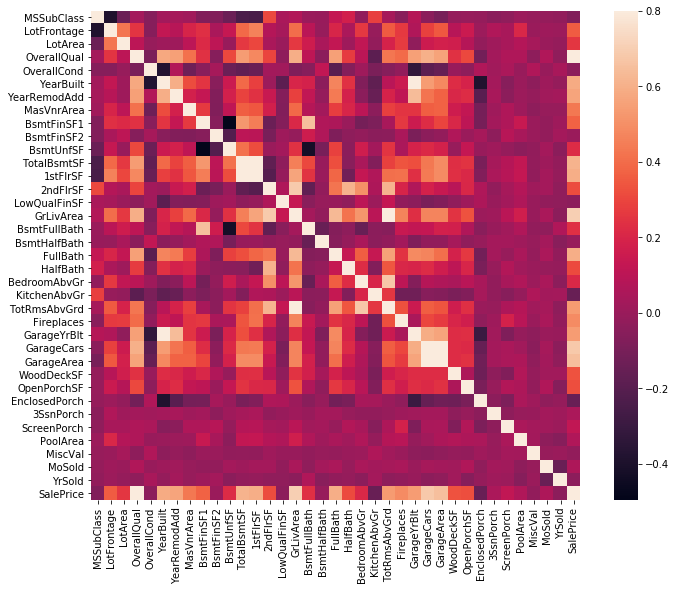

In [14]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

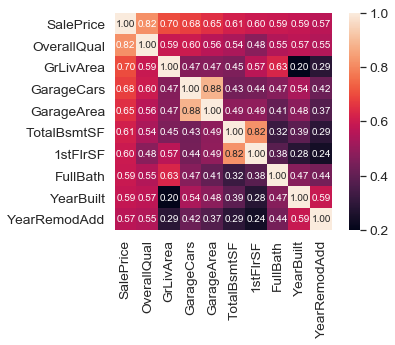

In [16]:
#saleprice correlation matrix
#number of variables for heatmap
k = 10 
# Question: what's the criterion to select these 10 variables and why? 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = train[cols].corr()
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Multicollinearity refers to a situation in which more than two explanatory variables in a multiple regression model are highly linearly related.

Three ways to handle this problem:

1. Remove some of the highly correlated independent variables.
2. Linearly combine the independent variables, such as adding them together.
3. Perform feature reduction for highly correlated variables, such as principal components analysis.

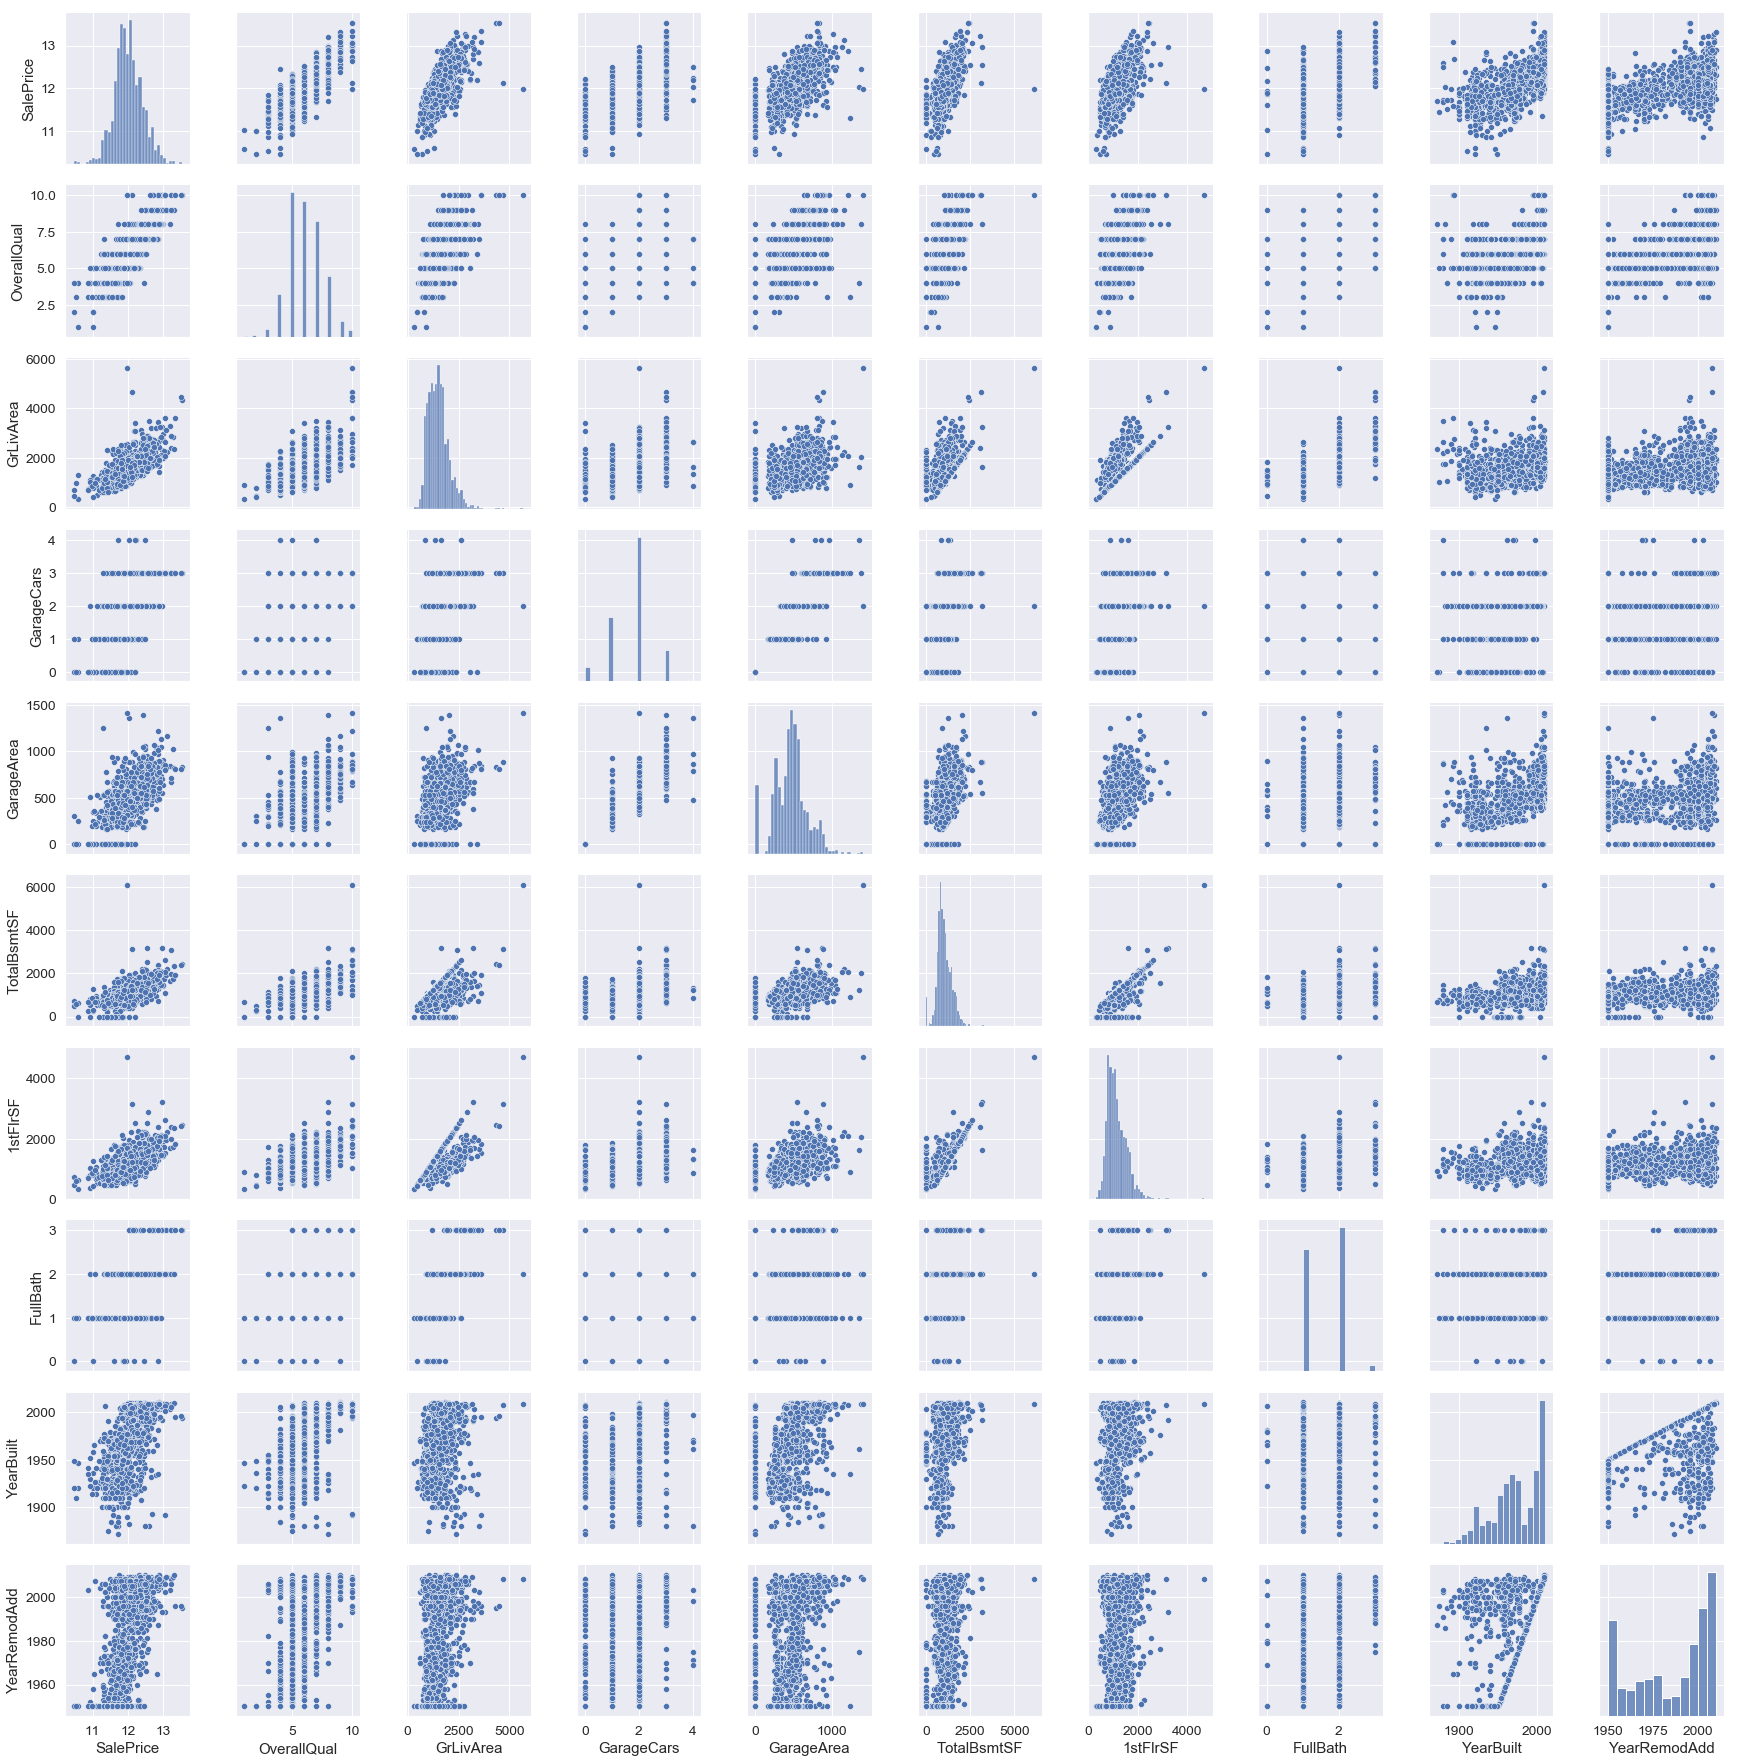

In [17]:
# scatterplot
# Question: What's your findings in the scatterplot?
# Hint: look at the relationships between basement and ground living area, year built vs year remodel. 
# sns.set()
# cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd']
sns.pairplot(train[cols], height = 2.5)
plt.show();

Missing Data

let's first  concatenate the train and test data in the same dataframe

In [18]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
#all_data = all_data[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt','YearRemodAdd']]
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


c:\users\long chen\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


In [19]:
print(all_data.shape)

(2919, 79)


In [22]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100

all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.657417
MiscFeature,96.402878
Alley,93.216855
Fence,80.438506
FireplaceQu,48.646797
LotFrontage,16.649538
GarageQual,5.447071
GarageCond,5.447071
GarageFinish,5.447071
GarageYrBlt,5.447071


Text(0.5, 1.0, 'Percent missing data by feature')

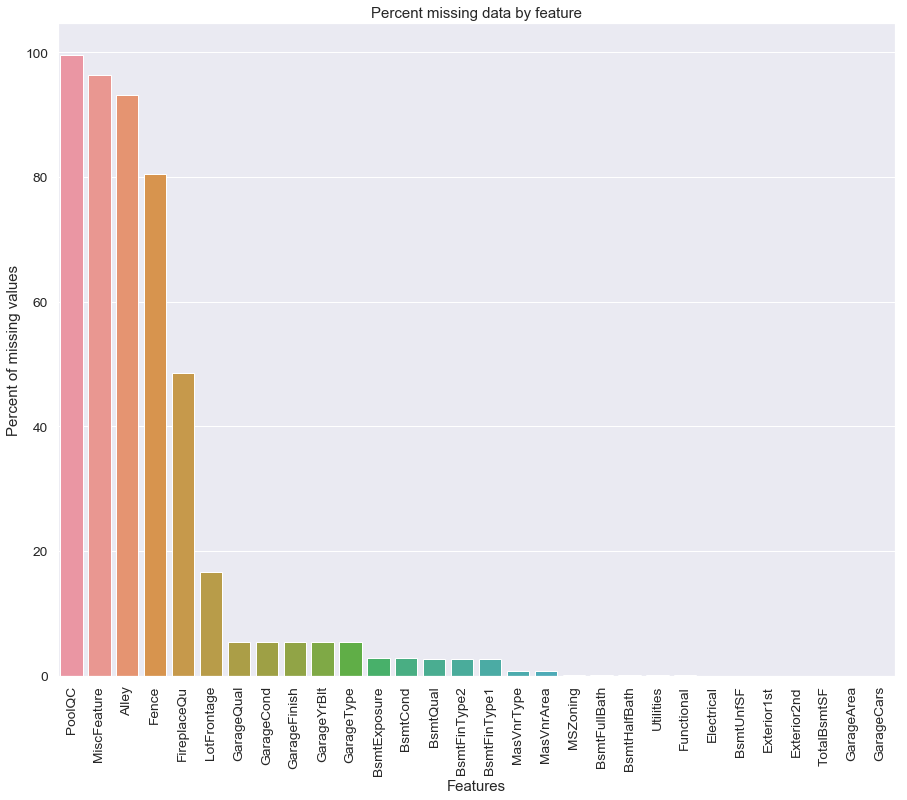

In [16]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [23]:
#drop the missing data
# print(all_data.head())
#all_data = all_data.drop(['Utilities'], axis=1)
all_data = all_data.drop((missing_data[missing_data['Missing Ratio'] > 0.6]).index,1)
#just checking that there's no missing data missing...

In [24]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio
MSZoning,0.137033
Utilities,0.068517
Functional,0.068517
BsmtHalfBath,0.068517
BsmtFullBath,0.068517


In [25]:
all_data["Utilities"].describe()

count       2917
unique         2
top       AllPub
freq        2916
Name: Utilities, dtype: object

In [30]:
# Why we drop Utilities?
all_data = all_data.drop(['Utilities'], axis=1)

## Imputing Missing Values

You can fill N/A values by 0, mean, median, the nearby observations, most frequent categories.

Sometimes you can delete the rows with many missing values, but we don't suggest to do it frequently.



In [26]:
all_data = all_data.fillna(0)

In [27]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [31]:
print(all_data.shape)

(2919, 60)


In [32]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,3,1Fam,706.0,0.0,1.0,0.0,150.0,...,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,3,1Fam,978.0,0.0,0.0,1.0,284.0,...,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,3,1Fam,486.0,0.0,1.0,0.0,434.0,...,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,3,1Fam,216.0,0.0,1.0,0.0,540.0,...,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,4,1Fam,655.0,0.0,1.0,0.0,490.0,...,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008


# Data Transformation

In [25]:
# MSSubClass=The building class, Changing Building Class into a categorical variable
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


# # Changing OverallCond into a categorical variable
# all_data['OverallCond'] = all_data['OverallCond'].astype(str)


# Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

# Comparisons between LabelEncoder and OneHotEncoder: https://towardsdatascience.com/choosing-the-right-encoding-method-label-vs-onehot-encoder-a4434493149b

LabelEncoder changes the categories to numbers. It is better to be used when the value of the categories is meaningful, such as the number of bedrooms. 

In [33]:
all_data['LandSlope'].value_counts()

Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64

In [27]:
from sklearn.preprocessing import LabelEncoder
cols = (   
        'ExterQual', 'ExterCond','HeatingQC', 'KitchenQual', 
         'Functional',   'LandSlope',
        'LotShape', 'PavedDrive', 'Street',  'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2919, 60)


In [34]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,...,SaleCondition,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,3,1Fam,706.0,0.0,1.0,0.0,150.0,...,Normal,WD,0,Pave,8,856.0,0,2003,2003,2008
1,1262,0,0,3,1Fam,978.0,0.0,0.0,1.0,284.0,...,Normal,WD,0,Pave,6,1262.0,298,1976,1976,2007
2,920,866,0,3,1Fam,486.0,0.0,1.0,0.0,434.0,...,Normal,WD,0,Pave,6,920.0,0,2001,2002,2008
3,961,756,0,3,1Fam,216.0,0.0,1.0,0.0,540.0,...,Abnorml,WD,0,Pave,7,756.0,0,1915,1970,2006
4,1145,1053,0,4,1Fam,655.0,0.0,1.0,0.0,490.0,...,Normal,WD,0,Pave,9,1145.0,192,2000,2000,2008


In [29]:
# Question: what did we do here? Hint: this is a feature engineering process. 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [31]:
all_data.drop(['TotalBsmtSF'],axis =1)
all_data.drop(['1stFlrSF'],axis =1)
all_data.drop(['2ndFlrSF'],axis =1)

,1stFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,CentralAir,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF
0,856,0,3,1Fam,706.0,0.0,1.0,0.0,150.0,1,...,WD,0,1,8,856.0,0,2003,2003,2,2566.0
1,1262,0,3,1Fam,978.0,0.0,0.0,1.0,284.0,1,...,WD,0,1,6,1262.0,298,1976,1976,1,2524.0
2,920,0,3,1Fam,486.0,0.0,1.0,0.0,434.0,1,...,WD,0,1,6,920.0,0,2001,2002,2,2706.0
3,961,0,3,1Fam,216.0,0.0,1.0,0.0,540.0,1,...,WD,0,1,7,756.0,0,1915,1970,0,2473.0
4,1145,0,4,1Fam,655.0,0.0,1.0,0.0,490.0,1,...,WD,0,1,9,1145.0,192,2000,2000,2,3343.0
5,796,320,1,1Fam,732.0,0.0,1.0,0.0,64.0,1,...,WD,0,1,5,796.0,40,1993,1995,3,2158.0
6,1694,0,3,1Fam,1369.0,0.0,1.0,0.0,317.0,1,...,WD,0,1,7,1686.0,255,2004,2005,1,3380.0
7,1107,0,3,1Fam,859.0,32.0,1.0,0.0,216.0,1,...,WD,0,1,7,1107.0,235,1973,1973,3,3197.0
8,1022,0,2,1Fam,0.0,0.0,0.0,0.0,952.0,1,...,WD,0,1,8,952.0,90,1931,1950,2,2726.0
9,1077,0,2,2fmCon,851.0,0.0,1.0,0.0,140.0,1,...,WD,0,1,5,991.0,0,1939,1950,2,2068.0


In [32]:
all_data.drop(['GarageCars'], axis = 1)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold,TotalSF
0,856,854,0,3,1Fam,706.0,0.0,1.0,0.0,150.0,...,WD,0,1,8,856.0,0,2003,2003,2,2566.0
1,1262,0,0,3,1Fam,978.0,0.0,0.0,1.0,284.0,...,WD,0,1,6,1262.0,298,1976,1976,1,2524.0
2,920,866,0,3,1Fam,486.0,0.0,1.0,0.0,434.0,...,WD,0,1,6,920.0,0,2001,2002,2,2706.0
3,961,756,0,3,1Fam,216.0,0.0,1.0,0.0,540.0,...,WD,0,1,7,756.0,0,1915,1970,0,2473.0
4,1145,1053,0,4,1Fam,655.0,0.0,1.0,0.0,490.0,...,WD,0,1,9,1145.0,192,2000,2000,2,3343.0
5,796,566,320,1,1Fam,732.0,0.0,1.0,0.0,64.0,...,WD,0,1,5,796.0,40,1993,1995,3,2158.0
6,1694,0,0,3,1Fam,1369.0,0.0,1.0,0.0,317.0,...,WD,0,1,7,1686.0,255,2004,2005,1,3380.0
7,1107,983,0,3,1Fam,859.0,32.0,1.0,0.0,216.0,...,WD,0,1,7,1107.0,235,1973,1973,3,3197.0
8,1022,752,0,2,1Fam,0.0,0.0,0.0,0.0,952.0,...,WD,0,1,8,952.0,90,1931,1950,2,2726.0
9,1077,0,0,2,2fmCon,851.0,0.0,1.0,0.0,140.0,...,WD,0,1,5,991.0,0,1939,1950,2,2068.0


## Outliers

Let's explore these outliers


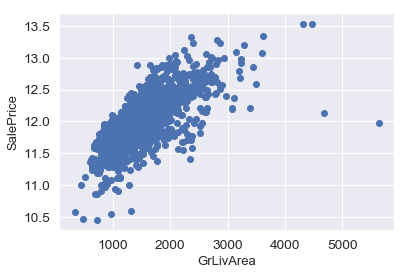

In [33]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


We can see at the bottom right two with extremely large GrLivArea that are of a low price. These values are huge oultliers.
Therefore, we can safely delete them.

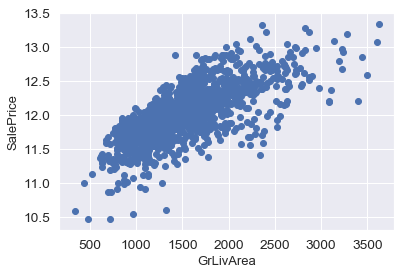

In [34]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
# train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']>700000)].index)
#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Note : 
 Outliers removal is not always safe.  We decided to delete these two as they are very huge and  really  bad (extremely large areas for very low  prices). 

There are probably others outliers in the training data.   However, removing all them  may affect badly our models if ever there were also  outliers  in the test data. That's why, instead of removing them all, we will just manage to make some of our  models robust on them. 

**Getting dummy categorical features**

Get dummy variables is the same as OneHot Encoder. 

See here for more information:
https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a

In [35]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 225)


In [36]:
all_data = np.log1p(all_data)

In [37]:
all_data.head(20)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave
0,6.753438,6.751101,0.000000,1.386294,6.561031,0.000000,0.693147,0.000000,5.017280,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147
1,7.141245,0.000000,0.000000,1.386294,6.886532,0.000000,0.000000,0.693147,5.652489,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147
2,6.825460,6.765039,0.000000,1.386294,6.188264,0.000000,0.693147,0.000000,6.075346,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147
3,6.869014,6.629363,0.000000,1.386294,5.379897,0.000000,0.693147,0.000000,6.293419,5.609472,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147
4,7.044033,6.960348,0.000000,1.609438,6.486161,0.000000,0.693147,0.000000,6.196444,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147
5,6.680855,6.340359,5.771441,0.693147,6.597146,0.000000,0.693147,0.000000,4.174387,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147
6,7.435438,0.000000,0.000000,1.386294,7.222566,0.000000,0.693147,0.000000,5.762051,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147
7,7.010312,6.891626,0.000000,1.386294,6.756932,3.496508,0.693147,0.000000,5.379897,5.433722,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147
8,6.930495,6.624065,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,6.859615,5.327876,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147
9,6.982863,0.000000,0.000000,1.098612,6.747587,0.000000,0.693147,0.000000,4.948760,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.693147,0.0,0.693147


Getting the new train and test sets. 

In [44]:
train = all_data[:ntrain]
test = all_data[ntrain:]


# Modelling

**Import librairies**

In [45]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
# Install lightbgm package: https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html#macos
import lightgbm as lgb
import xgboost as xgb

**Define a cross validation strategy**

We use the **cross_val_score** function of Sklearn. However this function has not a shuffle attribut, we add then one line of code,  in order to shuffle the dataset  prior to cross-validation

In [46]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

## Identifying the optimal parameters for each model with GridSearchCV

In [47]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'alpha':[10**-6, 10**-4, 10**-2, 0.1, 0.3, 0.5], 'l1_ratio': [0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]} # try 6*10=60 combinations  
]

ENet = ElasticNet()
grid_search = GridSearchCV(ENet, param_grid, cv=5, scoring='neg_mean_squared_error')  # each model is trained 5 times, so (12+6)*5 = 80 rounds of training in total
grid_search.fit(train.values, y_train)
grid_search.best_params_  # best parameters

c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You migh

c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You migh

c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\long chen\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You migh

{'alpha': 0.0001, 'l1_ratio': 1}

In [48]:
# GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# Tune the randome forest model


param_grid = [
    {'n_estimators':[10, 30,50], 'max_features': [15,30,45,100,120,140,160,180,195]},  # try 3x3=9 combinations
    #{'bootstrap': [False], 'n_estimators':[3, 10], 'max_features': [2, 3, 4]},  # try 2x3=6 combinations
]

rf = RandomForestRegressor()
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')  # each model is trained 5 times, so (12+6)*5 = 80 rounds of training in total
grid_search.fit(train.values, y_train)
grid_search.best_params_  # best parameters

{'max_features': 45, 'n_estimators': 50}

In [49]:
grid_search.best_estimator_ 

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=45, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

In [50]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=45, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

## Base models

-  **L1/L2 Regularization**  : 
https://towardsdatascience.com/ridge-and-lasso-regression-a-complete-guide-with-python-scikit-learn-e20e34bcbf0b

L1 Regularization: Lasso regression

L2 Regularization: Ridge regression

L1+L2 Regularization: Elastic Net regression

When you have many features, most of the model will have the overfitting problems. Regularization is a method to help select features in the model. 

The key difference between Lass and Ridge regression is that Lasso shrinks the less important feature’s coefficient to zero thus, removing some feature altogether. So, this works well for feature selection in case we have a huge number of features. 

-  **LASSO  Regression**  : 

This model may be very sensitive to outliers. So we need to made it more robust on them. For that we use the sklearn's  **Robustscaler()**  method on pipeline 

In [51]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

- **Elastic Net Regression** :

again made robust to outliers

Elastic Net regression: https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

In [52]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0001, l1_ratio=1, random_state=3))

- **Kernel Ridge Regression** :

Kernel Ridge Regression: https://scikit-learn.org/stable/modules/kernel_ridge.html

In [53]:
KRR = make_pipeline(RobustScaler(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5))

- **Advanced Tree-based Models **


With **huber**  loss that makes it robust to outliers

Gradient Boosting Regression: https://towardsdatascience.com/understanding-gradient-boosting-machines-9be756fe76ab
    

In [61]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

- **XGBoost** :

Explanation: https://xgboost.readthedocs.io/en/latest/tutorials/model.html

In [62]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)



- **LightGBM** :

Explanation: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [63]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### Base models scores

Let's see how these base models perform on the data by evaluating the  cross-validation rmsle (root mean squared logarithmic error) error and error score standard deviation. 

In [64]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1247 (0.0145)



In [65]:
score = rmsle_cv(rf)
print("\nRandom Forest score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Random Forest score: 0.1388 (0.0100)



In [66]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1267 (0.0165)



In [67]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1277 (0.0153)



In [68]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1246 (0.0132)



In [69]:
# score = rmsle_cv(model_xgb)
# print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

KeyboardInterrupt: 

In [70]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1233 (0.0110)



## Stacking  models

### Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models.  We build a new **class**  to extend scikit-learn with our model and also to laverage encapsulation and code reuse ([inheritance][1]) 


  [1]: https://en.wikipedia.org/wiki/Inheritance_(object-oriented_programming)

**Averaged base models class**

In [71]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

**Averaged base models score**

We just average four models here **ENet, GBoost,  KRR and lasso**.  Of course we could easily add more models in the mix. 

In [73]:
averaged_models = AveragingModels(models = (model_lgb, GBoost,  lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1186 (0.0128)



We get again a better score by adding a meta learner

## Ensembling StackedRegressor, XGBoost and LightGBM

We add **XGBoost and LightGBM** to the** StackedRegressor** defined previously. 

We first define a rmsle evaluation function 

In [74]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### Final Training and Prediction

**StackedRegressor:**

In [75]:
averaged_models.fit(train.values, y_train)
train_pred = averaged_models.predict(train.values)
stacked_pred = np.expm1(averaged_models.predict(test.values))
#print(rmsle(y_train, train_pred))

**XGBoost:**

In [78]:
# model_xgb.fit(train, y_train)
# xgb_train_pred = model_xgb.predict(train)
# xgb_pred = np.expm1(model_xgb.predict(test))
#print(rmsle(y_train, xgb_train_pred))

**LightGBM:**

In [79]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
#print(rmsle(y_train, lgb_train_pred))

In [80]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,train_pred*0.8 +
               lgb_train_pred*0.2 ))

RMSLE score on train data:
0.07596593835112227


**Ensemble prediction:**

In [81]:
ensemble = stacked_pred

**Submission**

In [82]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)